Spaecial cases of qnns are *Variational Quantum Classifier (VQC)* and *Variational Quantum Regressor (VQR)*

VQC takes:

* a feature map - a parameterized circuit for encoding the input
* an ansatz - a parameterized circuit to train
* a loss function 
* an optimizer (ex COBYLA)
* a sampler

VQR takes:

* a feature map - a parameterized circuit for encoding the input
* an ansatz - a parameterized circuit to train
* a loss function 
* an optimizer (ex COBYLA)
* an estimator

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorSampler 

algorithm_globals.random_seed = 42

# Classification

In [2]:
# Get the training data. We generate it
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}

for x, y_target in zip(X, y):
    print(f'Input: {x}.   Label: {y_target}')

Input: [ 0.5479121  -0.12224312].   Label: 1
Input: [0.71719584 0.39473606].   Label: 1
Input: [-0.8116453  0.9512447].   Label: 1
Input: [0.5222794  0.57212861].   Label: 1
Input: [-0.74377273 -0.09922812].   Label: -1
Input: [-0.25840395  0.85352998].   Label: 1
Input: [0.28773024 0.64552323].   Label: 1
Input: [-0.1131716  -0.54552256].   Label: -1
Input: [ 0.10916957 -0.87236549].   Label: -1
Input: [0.65526234 0.2633288 ].   Label: 1
Input: [ 0.51617548 -0.29094806].   Label: 1
Input: [0.94139605 0.78624224].   Label: 1
Input: [ 0.55676699 -0.61072258].   Label: -1
Input: [-0.06655799 -0.91239247].   Label: -1
Input: [-0.69142102  0.36609791].   Label: -1
Input: [0.48952431 0.93501946].   Label: 1
Input: [-0.34834928 -0.25908059].   Label: -1
Input: [-0.06088838 -0.62105728].   Label: -1
Input: [-0.74015699 -0.04859015].   Label: -1
Input: [-0.5461813   0.33962799].   Label: -1


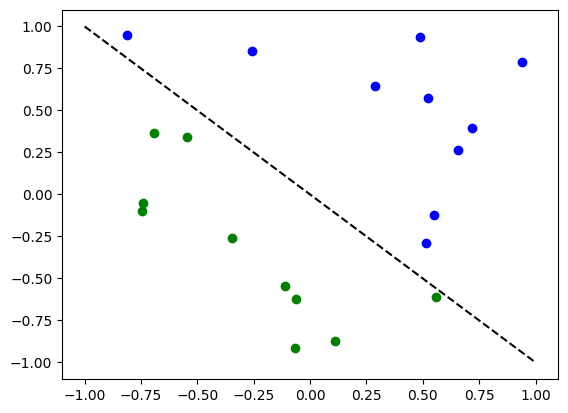

In [3]:
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

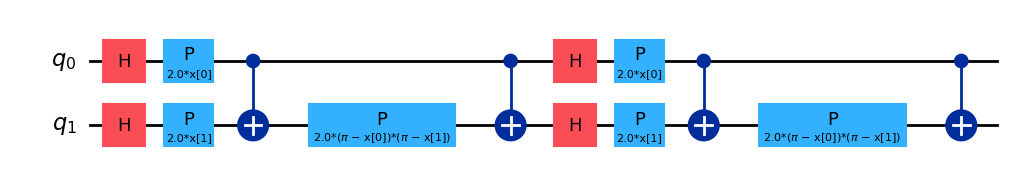

In [5]:
# Create input data loader
feature_map = ZZFeatureMap(num_inputs)
feature_map.decompose().draw('mpl')

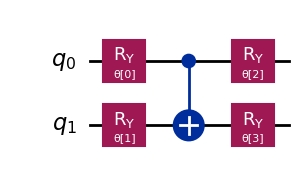

In [8]:
# Create ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.decompose().draw('mpl')

In [12]:
# create the VQC and train it

# use special encoding needed by the loss function "cross_entropy"
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    sampler=StatevectorSampler(),
)
vqc.fit(X, y_one_hot)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [13]:
# evaluate data points
y_predict = vqc.predict(X)

for x, label, predicted in zip(X, y, y_predict):
    print(f'Input: {x}.      Label: {label},     Predicted Label: {predicted}')

Input: [ 0.5479121  -0.12224312].      Label: 1,     Predicted Label: [0. 1.]
Input: [0.71719584 0.39473606].      Label: 1,     Predicted Label: [0. 1.]
Input: [-0.8116453  0.9512447].      Label: 1,     Predicted Label: [0. 1.]
Input: [0.5222794  0.57212861].      Label: 1,     Predicted Label: [1. 0.]
Input: [-0.74377273 -0.09922812].      Label: -1,     Predicted Label: [0. 1.]
Input: [-0.25840395  0.85352998].      Label: 1,     Predicted Label: [0. 1.]
Input: [0.28773024 0.64552323].      Label: 1,     Predicted Label: [0. 1.]
Input: [-0.1131716  -0.54552256].      Label: -1,     Predicted Label: [1. 0.]
Input: [ 0.10916957 -0.87236549].      Label: -1,     Predicted Label: [1. 0.]
Input: [0.65526234 0.2633288 ].      Label: 1,     Predicted Label: [0. 1.]
Input: [ 0.51617548 -0.29094806].      Label: 1,     Predicted Label: [1. 0.]
Input: [0.94139605 0.78624224].      Label: 1,     Predicted Label: [0. 1.]
Input: [ 0.55676699 -0.61072258].      Label: -1,     Predicted Label: [1

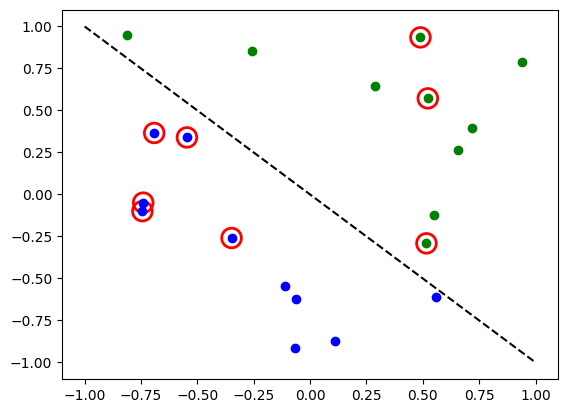

In [14]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# Regression

In [16]:
# Generate the data

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

for x, y_target in zip(X, y):
    print(f'Input: {x}.   Label: {y_target}')

Input: [2.0876499].   Label: 0.9232656052428181
Input: [1.91489093].   Label: 0.96281302822397
Input: [-0.7069942].   Label: -0.6258684780943661
Input: [-1.32997375].   Label: -1.0495620777278105
Input: [1.14665307].   Label: 0.7237187850823681
Input: [-2.2635019].   Label: -0.7948340394185393
Input: [-1.88553237].   Label: -1.0650442538926566
Input: [-3.09533415].   Label: -0.08283055169725334
Input: [1.80279903].   Label: 1.1145691000128441
Input: [1.03578848].   Label: 0.753840422984002
Input: [1.28909209].   Label: 0.7839041647966427
Input: [1.76387252].   Label: 0.8939721794821809
Input: [-0.2581398].   Label: -0.33784492203512845
Input: [0.43191367].   Label: 0.4833761066144906
Input: [-2.26322221].   Label: -0.746886722019975
Input: [-2.42197898].   Label: -0.5455348979863577
Input: [1.05810702].   Label: 0.9371539086170446
Input: [-0.18160789].   Label: -0.21805651201572623
Input: [0.40989055].   Label: 0.5241170966825197
Input: [1.66503693].   Label: 0.862351808150378


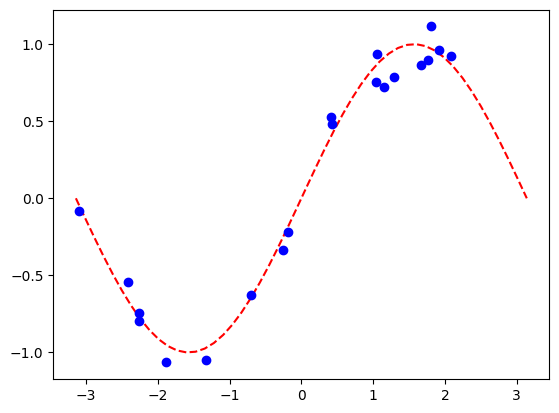

In [17]:
plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

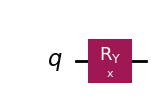

In [20]:
# construct feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

feature_map.draw('mpl')

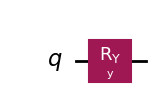

In [21]:
# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

ansatz.draw('mpl')

In [24]:
# train
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    estimator=StatevectorEstimator(),
)
vqr.fit(X, y)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


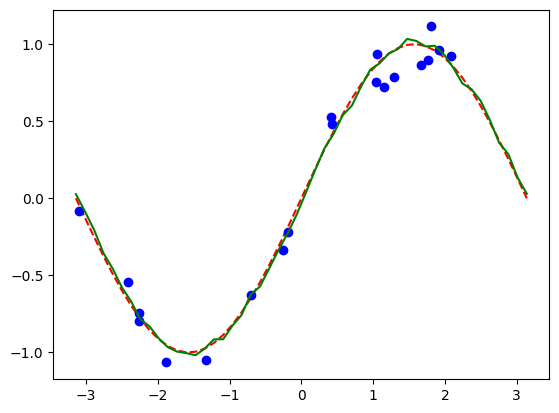

In [25]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()